# Practical Session 2

In [2]:
import numpy.random
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
import sklearn.datasets 

## Question 1

If we take the log of $\gamma_i(x)$ we have $log(\gamma_i(x)) = log(\pi_i) + log(\mathcal{N}(x,\mu_i,\Sigma_i)) - log(\sum_{i=1}^{N}\pi_i\mathcal{N}(x,\mu_i,\Sigma_i))$.

We can denote $v_i = log(\pi_i) + log(\mathcal{N}(x,\mu_i,\Sigma_i))$ and thus the denominator is equal to $log\sum_{i=1}^{N}exp(v_j)$

We have that $v_i = log(\pi_i) -\frac{d}{2}log2\pi-\frac{1}{2}log|\Sigma_i|-\frac{1}{2}(x_n -\mu_i)^T\Sigma_i^{-1}(x_n -\mu_i)$ and we have to calculate this directly. 

The difficulty that remains is the $|\Sigma_i|$ which can get very close to zero. The covariance matrix however has some properties : it is symetric semi-definite positive so we can use the Cholesky decompositon with $\Sigma_i = LL^T$. We then have that $|\Sigma_i| = |L|^2$ and $|L|$ is equal to the product of the diagonal elements of $L$, so the log will be the sum of the log of these values, ie $|\Sigma_i| = 2\sum_{i=1}^{d}log\lambda_i$

Note : we can be even more cautious by dividing by the lowest diagonal value to avoid small values in the sum.
$log|\Sigma_i| = 2\sum_{i=1}^{d}log\frac{\lambda_i}{\lambda_{min}} + dlog\lambda_{min}$ 

For the denominator we use the log_sum_exp trick seen in the previous lab to avoid NaN and we have the result.

In [2]:
def v_i(x, mu_i, sigma_i, pi_i): ## computes a single term v_i 
    
    L = numpy.linalg.cholesky(sigma_i)
    log_det_sigma_i = 2*np.sum(np.log(np.diag(L)))

    x_minus_mu_i = x - mu_i
    
    temp = -d*np.log(2*np.pi) - log_det_sigma_i - x_minus_mu_i.T.dot(np.linalg.inv(sigma_i).dot(x_minus_mu_i))
    result = np.log(pi_i) + temp/2.
    
    return result
    
def log_sum_exp(v):
    v_star = np.amax(v)
    return v_star + np.log(np.sum(np.exp(v-v_star)))

Note : we don't code the $\gamma_i(x_n)$ function here because we will embed it in the EM algorithm, see code of the E-step part.

## Question 2

#### We are going to minimize  $L^{(t)}(\theta)$according to the parameters $\Sigma_i$, $\mu_i$, $\pi_i$

with: 

$L^t(\theta) = \sum_n \sum_i \gamma^{t}(x_n)log(\mathcal{N}(x_n| \mu_i, \Sigma_i)) + \sum_n \sum_i \gamma^{t}(x_n)log(\pi_i) + n(1 - \sum_i \pi_i)$

Let's compute the parial derivatives:


\begin{aligned}
    \frac{\delta L^t(\theta)}{\delta \mu_i} &= \sum_n  \gamma^{t}(x_n)\frac{\delta log(\mathcal{N}(x_n| \mu_i, \Sigma_i))}{\delta \mu_i} + 0+0\\
    &=\sum_n  \frac{2\gamma^{(t)}(x_n)(\Sigma_i^{-1}(x_n -\mu_i))e^{(x_n - \mu_i)^{T}\Sigma_i^{-1}(x_n - \mu_i)}}{e^{(x_n - \mu_i)^{T}\Sigma_i^{-1}(x_n - \mu_i)}}\\
    &=\sum_n  2\gamma^{(t)}(x_n)(\Sigma_i^{-1}(x_n -\mu_i))\\
\end{aligned}



\begin{aligned}
    \frac{\delta L^t(\theta)}{\delta \Sigma_i} &= \sum_n  \gamma^{(t)}(x_n)(-\frac{1}{2}\frac{\delta log((2\pi)^d|\Sigma_i|)}{\delta \Sigma_i} - \frac{\delta (x_n - \mu_i)^{T}\Sigma_i^{-1}(x_n - \mu_i)}{\delta \Sigma_i})\\
    &= \sum_n  \gamma^{(t)}(x_n)(-\frac{1}{2}\frac{(2\pi)^d |\Sigma_i|\Sigma_i^{-1}}{(2\pi)^{d}|\Sigma_i|} +\frac{1}{2}{\Sigma_i^{-1}}^{2}(x_n - \mu_i)(x_n - \mu_i)^T)\\
\end{aligned}


\begin{aligned}
\frac{\delta L^t(\theta)}{\delta \Pi_i} &= \sum_n  \gamma^{(t)}(x_n) \frac{\delta log(\Pi_i)}{\delta\Pi_i}\\
&= \sum_n  \gamma^{(t)}(x_n)\frac{1}{\pi_i}\\
\end{aligned}



  - (I)To compute $\frac{\delta (x_n - \mu_i)^{T}\Sigma_i^{-1}(x_n - \mu_i)}{\delta \Sigma_i}$

Let's begin by calculating $\frac{\delta (x_n - \mu_i)^{T}\Sigma_i(x_n - \mu_i)}{\delta \Sigma_i}$ then we will calculate the gradient of the compoud function with the inverse function in the NOTA BENE.

Let 
$v = (x_n - \mu_i)$

$(x_n - \mu_i)^{T}\Sigma_i(x_n - \mu_i) = \sum_i \sum_j v_i v_j \sigma_{ij}$
So,

$\frac{\delta (x_n - \mu_i)^{T}\Sigma_i(x_n - \mu_i)}{\delta \sigma_{ij}} = v_i v_j$


So,


$\frac{\delta (x_n - \mu_i)^{T}\Sigma_i(x_n - \mu_i)}{\delta \Sigma_i} = vv^T = (x_n - \mu_i)(x_n - \mu_i)^{T} $

- (II) To compute  $\frac{\delta (x_n - \mu_i)^{T}\Sigma_i^{-1}(x_n - \mu_i)}{\delta \mu_i}$ we will introduce a vector $h$

\begin{aligned}
(x_n - (\mu_i + h))^{T}\Sigma_i^{-1}(x_n - (\mu_i + h)) &= (x_n - \mu_i )^{T}\Sigma_i^{-1}(x_n - \mu_i) +h^{T}\Sigma_i^{-1}(x_n - \mu_i) + (x_n - \mu_i)^{T}\Sigma_i^{-1}h\\
&= <h;\Sigma_i^{-1}(x_n - \mu_i)> + <x_n - mu_i; \Sigma_i^{-1}h>\\
&= 2<h;\Sigma_i^{-1}(x_n - \mu_i)> because {{\Sigma_i}^{-1}}^{T} = {\Sigma_i}^{-1}
\end{aligned}

So $\frac{\delta (x_n - \mu_i)^{T}\Sigma_i^{-1}(x_n - \mu_i)}{\delta \mu_i} = 2\Sigma_i^{-1}(x_n - \mu_i)$

**NOTA BENE:**


- **For the calculation of   $\frac{\delta det(M)}{\delta M}$**


Let H be a matrix of same dimension as M:  $det(M + H) = det(M(I + M^{-1}H)) = det(X)(1 + Tr(M^{-1}H)) + o(H) = det(X) + Tr(det(X)X^{-1}H) + o(H)$

donc,


$det(X+H) - det(X) = Tr(Com(X)^TH) + o(H)$


and so, 
$\frac{\delta det(M)}{\delta(M)} = com(M)$


 - **For the calculation of  $\frac{\delta M^{-1}}{\delta(M)}$: **

It appears to be the same formula as for a function  $\mathbb{R} \rightarrow \mathbb{R}$ qui $x: \rightarrow \frac{1}{x}$


Let: 


$\frac{\delta M^{-1}}{\delta M} = -{\frac{1}{2} M^{-1}}^{2}$




- When we evlauate the system to 0 to compute the max of $L^t(\theta)$ we obtain the following system:

$\left\{
\begin{array}{l}
  \sum_n  2\gamma^{(t)}(x_n)({\Sigma_i^{-1}}^{T}(x_n -\mu_i)) = 0 (1)\\
  \sum_n  \gamma^{(t)}(x_n)(-\frac{1}{2}\Sigma_i^{-1} +\frac{1}{2} \Sigma_i^{-2}(x_n - \mu_i)(x_n - \mu_i)^T) = 0 (2)\\
  \sum_n  \gamma^{(t)}(x_n)\frac{1}{\pi_i}-n = 0 (3)\\
\end{array}
\right.$


as $\Sigma_i^{T}$ is an invertible matrix (1) $\leftrightarrow \sum_n  2\gamma^{(t)}(x_n)(x_n -\mu_i) = 0\leftrightarrow \mu_i = \frac{\sum_n \gamma_i^{(t)}(x_n)x_n}{\sum_n \gamma_i^{(t)}(x_n)}$

Now when we multiply (2) by $\Sigma_i^2$ we obtain: 


$\sum_n  \gamma^{(t)}(x_n)(-\frac{1}{2} \Sigma_i + \frac{1}{2}(x_n - \mu_i)(x_n - \mu_i)^T) = 0\leftrightarrow \Sigma_i = \frac{\sum_n \gamma_i^{(t)}(x_n - \mu_i)(x_n - \mu_i)^T}{\sum_n \gamma_i^{(t)}(x_n)}$


finally for the last equation: 
$(3) \leftrightarrow \pi_i = \frac{\sum_n \gamma_i^{(t)}(x_n)}{n}$



## Question 3

## 1. Generating the dataset

[[0 0 1]
 [1 0 0]
 [1 0 0]
 ...
 [1 0 0]
 [0 1 0]
 [0 0 1]]


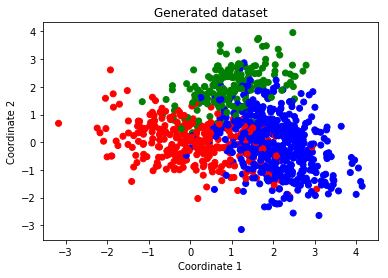

In [3]:
## Parameter initialization
N = 1000
d = 2
K = 3
pi1, pi2, pi3 = 0.3, 0.2, 0.5
mu1, mu2, mu3 = [0,0],[1,2],[2,0]
sigma1 = [[1,-0.25],[-0.25,0.50]]
sigma2 = [[0.50,0.25],[0.25,0.50]]
sigma3 = [[0.50, -0.25],[-0.25, 1]]

true_pi = np.array([pi1, pi2, pi3])
true_mu = np.array([mu1, mu2, mu3])
true_sigma = np.array([sigma1, sigma2, sigma3])


### Dataset generation
Z = numpy.random.multinomial(n = 1,pvals = [pi1,pi2,pi3],size=N)
Z = np.argmax(Z,axis=1)
X = np.zeros((N,2))
C = []
for i in range(N):
    if Z[i] == 0:
        X[i] = numpy.random.multivariate_normal(mu1,sigma1,1)
        C.append('red')
    elif Z[i] == 1:
        X[i] = numpy.random.multivariate_normal(mu2,sigma2,1)
        C.append('green')

    else:
        X[i] = numpy.random.multivariate_normal(mu3,sigma3,1)
        C.append('blue')

X = np.reshape(X,(N,d))

### Plots 
colours = []

fig, ax = plt.subplots()

ax.scatter(X[:,0],X[:,1],c = C)

plt.title('Generated dataset')
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.show()

## 2. Implementation of the EM algorithm

Here we write a bunch of functions for the next three sub-questions

In [21]:
## aimplementation of the EM algorithm
def EM(X, mu_0, sigma_0, pi_0, n_iter): 

    mu, sigma, pi = np.array(mu_0), np.array(sigma_0), np.array(pi_0) # setting parameters to initial parameters 
    log_l_list, mu_list, sigma_list, pi_list = [],[mu_0.copy()],[sigma_0.copy()],[pi_0.copy()] # creating list for keeping track of values
    
            
    for iteration in range(n_iter):
        
        ## E-Step
        log_l = 0
        gamma = np.zeros((N,K)) # initializing gamma matrix
        for n in range(N):
            v = np.array([v_i(X[n],mu[i],sigma[i],pi[i]) for i in range(K)])
            log_l += log_sum_exp(v)
            gamma[n,:] = np.exp(v - log_sum_exp(v))
        
        
        ## M-Step
        for i in range(K): 

            N_i = np.sum(gamma[:,i]) # number of points assigned to cluster i 

            # computing update of mu_i
            mu_i = np.zeros((1, d)) 
            for n in range(N): 
                mu_i += gamma[n,i]*X[n]
            mu_i /= N_i

            # computing update of sigma_i
            sigma_i = np.zeros((d, d)) 
            for n in range(N):
                x_n_minus_mu_i = (X[n] - mu_i).reshape((d,1))
                sigma_i += gamma[n,i]*np.dot(x_n_minus_mu_i, np.transpose(x_n_minus_mu_i))
            sigma_i /= N_i
            
            # computing update of pi_i
            pi_i = N_i/N


            # making the updates
            mu[i] = mu_i.copy()
            sigma[i] = sigma_i.copy()
            pi[i] = pi_i.copy()
        
        # saving the intermediate results 
        mu_list.append(mu)
        sigma_list.append(sigma)
        pi_list.append(pi)
        log_l_list.append(log_l)
        
    ## computating of log-likelihood for last iteration     
    log_l = 0
    for n in range(N):
        v = np.array([v_i(X[n],mu[i],sigma[i],pi[i]) for i in range(K)])
        log_l += log_sum_exp(v)
    log_l_list.append(log_l)

        
    
    return log_l_list, mu_list, sigma_list, pi_list



def init(init_type):
    if init_type == 'random_far':
        mu_0 = np.random.uniform(-1 , 1,size=(K,d))
        pi_0 = np.ones(K)/K
        sigma_0 = np.random.uniform(-1 , 1,size=(K,d,d))
        # make the matrices semi positive definite
        sigma_0 = np.array([A.dot(A.T) for A in sigma_0])
        
    elif init_type == 'random_close':
        mu_0 = np.array(true_mu) + np.random.uniform(-1 , 1,size=(K,d))/50
        pi_0 = np.array(true_pi) + np.ones(K)/(50*K)
        
        sigma_add = np.random.uniform(-1 , 1,size=(K,d,d))
        sigma_add = np.array([A.dot(A.T) for A in sigma_add])
        
        sigma_0 = np.array(true_sigma) + sigma_add/50.
        
    elif init_type == 'k_means':
        kmeans = KMeans(n_clusters=K).fit(X) 
        mu_0 = kmeans.cluster_centers_
        sigma_0 = np.zeros((K,d,d))
        for i in range(K):
            sigma_0[i] = np.random.uniform(0,0.5,size =1)*np.eye(d)
        pi_0 = np.ones(K)/K
        
        
    print('One of the init means:' + str(mu_0[0]))
    print('One of the init covariance matrix: ')
    print(sigma_0[0])
    print('Init weights: ' + str(pi_0))
    
    return mu_0, sigma_0, pi_0
        
        
## a function that plots the contours of the results
def plot_EM_contours(mu_list, sigma_list):
    i = 0 
    color_dict = {0:'red', 1:'green', 2:'blue'}
    x, y = np.mgrid[-5:5:.01, -5:5:.01]

    f = plt.figure(figsize=(20,5))
    ax1 = f.add_subplot(131)
    ax2 = f.add_subplot(132)
    ax3 = f.add_subplot(133)
    axes = [ax1,ax2,ax3]

    ax1.scatter(X[:,0],X[:,1], c = 'grey')
    for j in range(3):
        axes[j].scatter(X[:,0],X[:,1], c = 'grey')
        for k in range(K):
            rv = multivariate_normal(mu_list[i][k], sigma_list[i][k])
            pos = np.dstack((x, y))
            axes[j].contour(x,y,rv.pdf(pos),levels=2,colors = color_dict[k])
            axes[j].title.set_text('Iteration ' + str(i))
        i+= n_iter//2
    plt.show()
    
## a function to plot the log-likelihoods
def plot_log_l(log_l_list, start = 0):
    x_axis = range(start,len(log_l_list))
    plt.plot(x_axis, log_l_list[start:])
    plt.title('Log-likelihood')
    plt.xlabel('Iterations')
    plt.ylabel('Value')
    plt.show()

### (a) First run with random parameters and plotting of the contours

We then run the algorithm on 20 iterations with a random initialization (means and variances not close to the true ones and weights equal to 1/K):

In [18]:
n_iter = 40
mu_0, sigma_0, pi_0 = init('random_far')
log_l_list, mu_list, sigma_list, pi_list = EM(X, mu_0, sigma_0, pi_0, n_iter)

One of the init means:[-0.46430004  0.48078499]
One of the init covariance matrix: 
[[ 0.60458657 -0.49897593]
 [-0.49897593  1.29586503]]
Init weights: [0.33333333 0.33333333 0.33333333]


We plot the results:

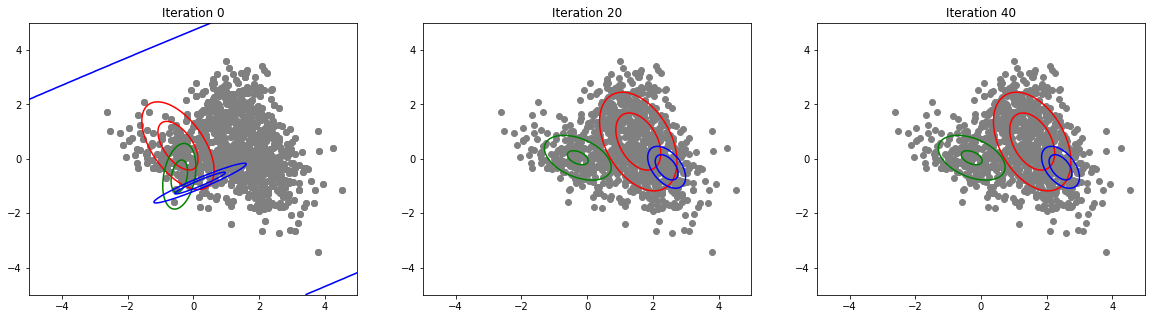

In [19]:
plot_EM_contours(mu_list, sigma_list)

### (b) Plot of log-likelihood

We plot the log-likelihood:

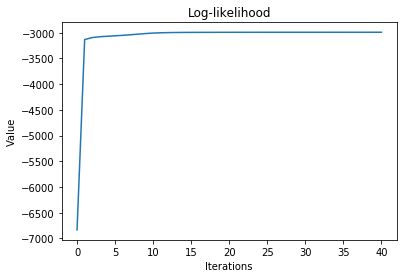

In [24]:
plot_log_l(log_l_list)

We can remove the first log-likelihood which is obviously very low (the algorithm hasn't started yet) to better see the convergence:

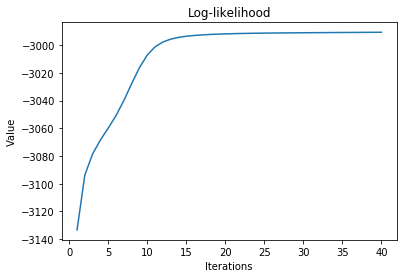

In [26]:
plot_log_l(log_l_list,start = 1)

We see more clearly that the algorithm converges in about 20 iterations

### (c) Different initializations

We can for example try three types of initialization to see how the algorithm is affected. 

* First, a truly random initialiation where means and variances are far from the true ones, which is what we did above.
* Then, an initialization where the means and variances are still random but we try to have them close to the true ones. 
* Finally, as seen in the litterature, we try to initialize the means after a first pass of the K-Means algorithm, and variances proportional to the unit matrix. 

We will plot the log-likelihoods in each case.

In [9]:
n_iter = 30

#### Initializaton with means and variances far from the true ones

One of the init means:[-0.21744261  0.57665201]
One of the init covariance matrix: 
[[ 0.03299803 -0.12762191]
 [-0.12762191  0.49397193]]
Init weights: [0.33333333 0.33333333 0.33333333]


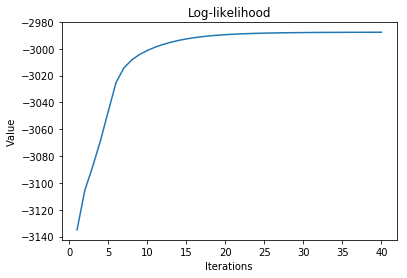

In [29]:
mu_0, sigma_0, pi_0 = init('random_far')
plot_log_l(EM(X, mu_0, sigma_0, pi_0, n_iter)[0],start = 1)

#### Initializaton with means and variances close to the true ones

One of the init means:[ 0.0153062  -0.01927298]
One of the init covariance matrix: 
[[ 1.02531527 -0.24433201]
 [-0.24433201  0.52637522]]
Init weights: [0.30666667 0.20666667 0.50666667]


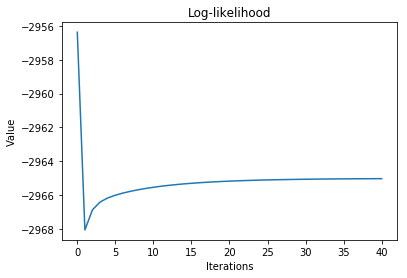

In [30]:
mu_0, sigma_0, pi_0 = init('random_close')
plot_log_l(EM(X, mu_0, sigma_0, pi_0, n_iter)[0])

In that case wee see that the algorithm doesn't bring anything ie. if we know the parameters quite precisely already we won't be able to find them more precisely with the algo. 

#### Initializaton with KMeans and variances proportional to unit matrix

One of the init means:[-0.23239571  0.13526305]
One of the init covariance matrix: 
[[0.47601034 0.        ]
 [0.         0.47601034]]
Init weights: [0.33333333 0.33333333 0.33333333]


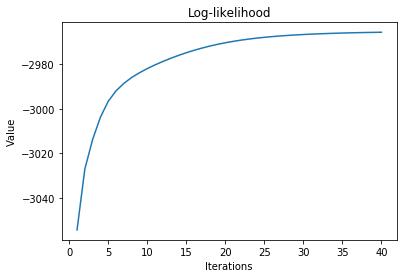

In [32]:
mu_0, sigma_0, pi_0 = init('k_means')
plot_log_l(EM(X, mu_0, sigma_0, pi_0, n_iter)[0],start = 1)

We note that we get closer to the true solutions when starting with these parameters.